In [1]:
import os
import torch
import torch.nn as nn
import  torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import  urllib.request as req

plt.style.use("fivethirtyeight")

## Download data

In [2]:
data_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

## Create a directory

In [3]:
def create_dirs(dir_path):
    os.makedirs(dir_path, exist_ok=True)
    print(f"{dir_path} directory created")

ROOT_DATA_DIR = "hymenoptera_data"
create_dirs(ROOT_DATA_DIR)


hymenoptera_data directory created


In [4]:
data_zip_file = "data.zip"
data_zip_path = os.path.join(ROOT_DATA_DIR, data_zip_file)

if not os.path.isfile(data_zip_file):
    print("downloading data...")
    filename, headers = req.urlretrieve(data_url, data_zip_path)
    print(f"filename: {filename} created with info \n{headers}")
else:
    print(f"file is already present")

downloading data...
filename: hymenoptera_data/data.zip created with info 
Content-Type: application/zip
Content-Length: 47286322
Connection: close
Last-Modified: Wed, 15 Mar 2017 18:46:00 GMT
x-amz-version-id: null
Accept-Ranges: bytes
Server: AmazonS3
Date: Tue, 06 Jan 2026 08:26:59 GMT
ETag: "5f8c32a6554f6acb4d649776e7735e48"
X-Cache: RefreshHit from cloudfront
Via: 1.1 31ad3648f2f9f8e2686635a4603ce0bc.cloudfront.net (CloudFront)
X-Amz-Cf-Pop: ORD56-P5
X-Amz-Cf-Id: kxszItxQQjWLHfLdvHFVENhBPrwWQaetwFQpIQJOEiBkT5N_Pjzjww==




## Unzip data

In [5]:
from zipfile import ZipFile

unzip_data_dir = "unzip_data_dir"
unzip_data_dir = os.path.join(ROOT_DATA_DIR, unzip_data_dir)

if not os.path.exists(unzip_data_dir):
    os.makedirs(unzip_data_dir, exist_ok=True)
    with ZipFile(data_zip_path) as f:
        f.extractall(unzip_data_dir)
else:
    print(f"Data already extracted")

## Create data loaders

In [8]:
Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/train")

PosixPath('hymenoptera_data/unzip_data_dir/hymenoptera_data/train')

In [9]:
os.path.isdir(Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/train"))

True

In [ ]:
from pathlib import Path

In [10]:
train_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/train")
test_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/test")

In [11]:
img_size = (224, 224)

In [12]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

## Transformations

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [14]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data = datasets.ImageFolder(root=train_path, transform=test_transforms)

In [15]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [17]:
label_map = train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [18]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/unzip_data_dir/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [19]:
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [20]:
data = next(iter(train_loader))

In [21]:
len(data)

2

In [22]:
images,labels = data

In [23]:
images.shape

torch.Size([64, 3, 224, 224])

In [24]:
labels.shape

torch.Size([64])

## Download and use pre-trained model

In [28]:
model = models.alexnet(weights=True)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
def count_both_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = {"trainable": 0, "non-trainable": 0}
    for name, parameters in model.named_parameters():
        param = parameters.numel()
        if not parameters.requires_grad:
            total["non-trainable"] += param
            continue

        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total["trainable"] += param

    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total Trainable Parameters: {total['trainable']}\nNon-Trainable Parameters: {total['non-trainable']}")
    return df

count_both_params((model))

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


## Freezing all the model layers

In [33]:
for parameters in model.parameters():
    parameters.requires_grad = False

In [34]:
count_both_params(model)

,Modules,Parameters


In [35]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [37]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [38]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [39]:
count_both_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Training loop

In [42]:
num_epochs = 20

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [44]:
for epoch in range(num_epochs):
    with tqdm(train_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backword pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 20/20: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it, loss=0.0236]


In [45]:
ROOT_MODEL_DIR = "models"
os.makedirs(ROOT_MODEL_DIR, exist_ok=True)
MODEL_FILE = "trans_model.pth"
MODEL_FILE_PATH = os.path.join(ROOT_MODEL_DIR, MODEL_FILE)

torch.save(model, MODEL_FILE_PATH)

## Evaluate our model

In [46]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_loader):
        image, label = data[0].to(device), data[1].to(device)
        y_pred = model(image)
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target,label.cpu().numpy()))

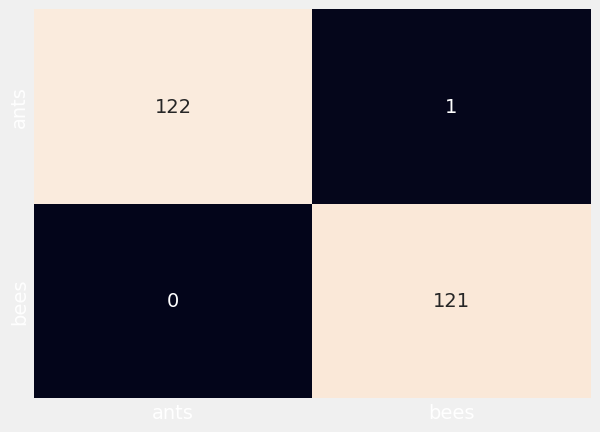

In [52]:
cm = confusion_matrix(target, pred)
# plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cbar=False)
plt.show()

## Prediction

In [54]:
data = next(iter(test_loader))
len(data)

2

In [55]:
images, labels = data

In [56]:
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [57]:
img = images[2]

In [58]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.77254903].


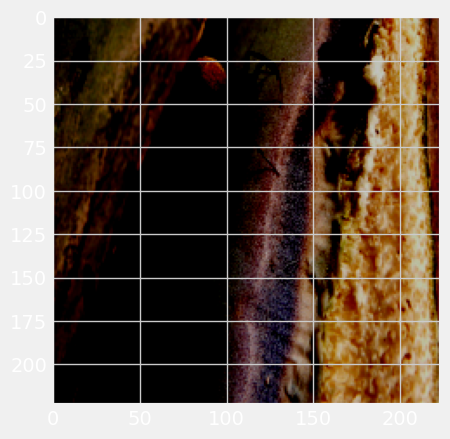

In [59]:
plt.imshow(img.permute(1,2,0))
plt.show()

$normalized_data = (data - mean) / std$

$normalized_data * std = (data - mean)$

$data = normalized_data * std + mean$

In [62]:
img.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [63]:
img = img.unsqueeze(0).to(device)

pred_prob = F.softmax(model(img), dim=1)

In [64]:
pred_prob

tensor([[1.0000e+00, 1.8141e-06]], grad_fn=<SoftmaxBackward0>)

In [65]:
arg_max = torch.argmax(pred_prob).item()

In [66]:
inverse_label_map = {val: key for key, val in label_map.items()}
inverse_label_map

{0: 'ants', 1: 'bees'}

In [68]:
inverse_label_map[arg_max], inverse_label_map[labels[2].item()]

('ants', 'ants')

In [69]:
def prediction_viz(img, pred_prob, label_map, FIG_SIZES=(10,15)):
    pred_prob = pred_prob.cpu().data.numpy().squeeze()
    _, (ax1, ax2) = plt.subplots(figsize=FIG_SIZES, ncols=2)

    # unnormalize the img
    img = img.cpu() * std[:, None, None] + mean[:, None, None]
    ax1.imshow(img.squeeze().permute(1,2,0).cpu())
    ax1.axis("off")
    ax2.barh(np.arange(2), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(label_map.keys(), size="small")
    ax2.set_title("Prediction Probability")
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

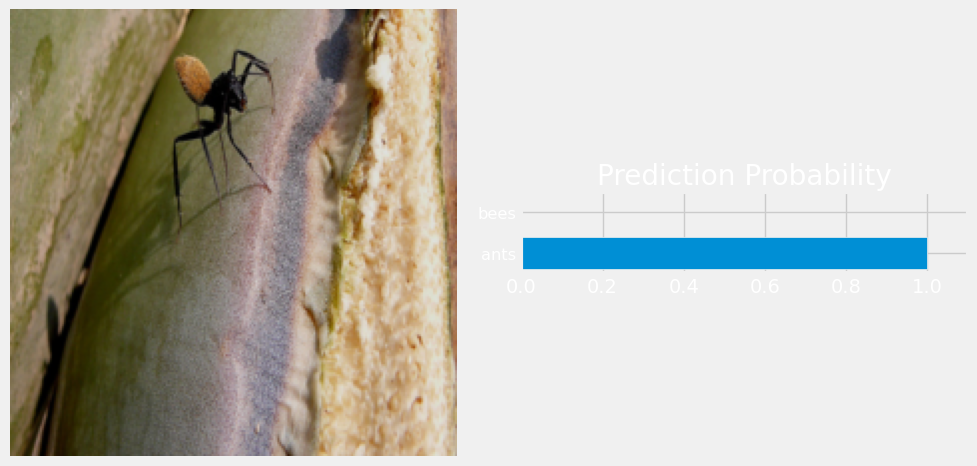

In [70]:
prediction_viz(img, pred_prob, label_map)